In [2]:
import parse
import learning_curve
import numpy as np
import importlib
import ID3
import copy
from matplotlib import pyplot as plt

## Question 1
The Node data structure was not conceptually changed, we added attributes in order for us to be able to form the tree.

We've added a few attributes to the Node class to faciliate the learning process:

- Node.attribute - splitting attribute for nodes

- Node.value - assigned value for leaf nodes. Both were kept whether the node was
a leaf or not in order to maintian one unified structure for the nodes.

- Node.is_leaf was added for convenience (Checking len(self.children is also an option)).

- Node.node_info_gain - finds the info gain of the current node (0 for leaf nodes). This is needed for certain pruning strategies.

- Node.parent - parent node of the current Node. None for root node. This is needed for certain pruning strategies, as discussed below.

We've also added 2 methods for the node:

- Node.add_child() - adds a child node to the current node. This is necessary for building the tree, as the Node class is a de factor tree in this case.

- Node.get_root() - traveses the Node (the tree, essentially) and returns the root Node who has no parent. This is necessary for the recursive call in the pruning stage.

## Question 2
We implemented the tree such that it can handle more than two classes , so a case of an "?" is also handled. We got good accuracy results doing that on the house votes dataset, even without pruning.

In [3]:
test_size = 45

data = parse.parse("house_votes_84.data")

#Split to train and test
train = data[:-test_size]
test_ = data[-test_size:]
print(f"Train dataset size : {len(train)}, Test dataset size : {len(test_)}")

#train
tree = ID3.ID3(train, "democrat")

#calculate accuarcy
acc = ID3.test(node = tree, examples=test_)
print(f"The tree has accuracy of : {100.0*acc:.2f}%")

Train dataset size : 390, Test dataset size : 45
The tree has accuracy of : 93.33%


## Question 3

In this homework, we employed Reduced Error Pruning (REP) for our pruning strategy. This is a straight forward post-pruning method that recursively evaluate each non-leaf node from the bottom, temporarily pruning subtrees and converting them to leaves while retaining changes only if they improve validation accuracy. This effectively reduces complexity of the trained decision tree and improves test accuracy, as can be seen in the example below:


In [9]:
q3_training_data = parse.parse("cars_train.data")

result = ID3.ID3(q3_training_data, default="acc")
pruned_result = copy.deepcopy(result)

q3_validation_data = parse.parse("cars_valid.data")
ID3.prune(pruned_result, q3_validation_data)

q3_testing_data = parse.parse("cars_test.data")
unpruned_accuracy = ID3.test(result, q3_testing_data)
pruned_accuracy = ID3.test(pruned_result, q3_testing_data)
print(f"Accuracy: {unpruned_accuracy*100:.2f}%")
print(f"Pruned Accuracy: {pruned_accuracy*100:.2f}%")


Accuracy: 71.88%
Pruned Accuracy: 78.12%


## Question 4

The training set has 300 examples.


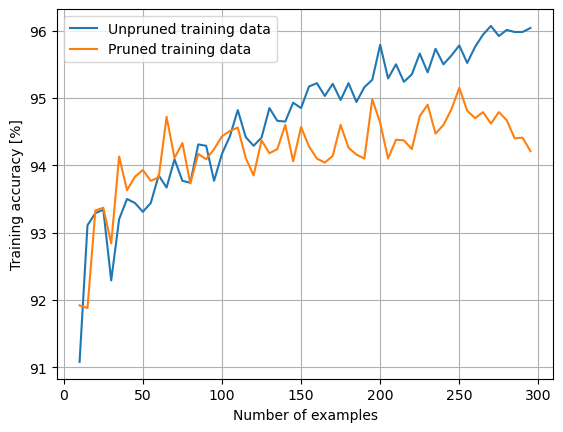

In [5]:
importlib.reload(learning_curve)

train_size = 300
test_size = 100
interations = 100

data = parse.parse("house_votes_84.data")

#Split to train and test and validate
test = data[:test_size]
train = data[test_size:test_size+train_size]
validate = data[:-test_size-train_size]

print(f"The training set has {len(train)} examples.")

example_size = np.arange(10,len(train),5)

learn_curve = np.zeros_like(example_size,dtype='float64')

for it in range(interations):
    learn_curve += learning_curve.get_learning_curve_data(examples_sizes=example_size,train_data=train,test_data=test,valid_data=validate,default = "democrat")

learn_curve /= interations

pruned_learn_curve = np.zeros_like(example_size,dtype='float64')

for it in range(interations):
    pruned_learn_curve += learning_curve.get_learning_curve_data(examples_sizes=example_size,train_data=train,test_data=test,valid_data=validate,default = "democrat",prune=True)

pruned_learn_curve /= interations


plt.plot(example_size,learn_curve*100, label = 'Unpruned training data')
plt.plot(example_size,pruned_learn_curve*100, label = 'Pruned training data')
plt.xlabel("Number of examples")
plt.ylabel("Training accuracy [%]")
plt.grid()
plt.legend()
plt.show()

### a. 
The general trend is that the accuarcy increases as we provide more examples. However, given a big enough training set, we might expect the learning curve to slump on the test set accuracy, at which point overfitting/data memorization occurs. 

### b.

Pruning might prevent overfitting from occuring. In the long run, we should expect it to outperform the unpruned learning curve as the size of the training data grows. However, given the current data set size, we have yet to observe that from the learning curves above.

## Question 5


Without pruning:

In [6]:
importlib.reload(ID3)

train = parse.parse("cars_train.data")
test  = parse.parse("cars_test.data")
validate = parse.parse("cars_valid.data")

cars_tree = ID3.ID3(train,default = "unacc")
print("Accuracies:")
acc_train = ID3.test(cars_tree,train)*100
acc_test = ID3.test(cars_tree,test)*100
acc_valid = ID3.test(cars_tree,validate)*100
print(f"Train: {acc_train:.2f}% , Test: {acc_test:.2f}% , Validate: {acc_valid:.2f}%")


Accuracies:
Train: 100.00% , Test: 71.88% , Validate: 78.12%


### Explanation:
The accuracy for the train data is 100% - the ID3 tree was trained on this data, and thus is fit to it very well - possibly too well, as both the test and validate yeild lower accuracies. This might suggest that the tree is overfit to the training data.

With pruning:

In [7]:
importlib.reload(ID3)

train = parse.parse("cars_train.data")
test  = parse.parse("cars_test.data")
validate = parse.parse("cars_valid.data")

cars_tree = ID3.ID3(train,default = "unacc")
ID3.prune(cars_tree,validate)
print("Accuracies:")
acc_train = ID3.test(cars_tree,train)*100
acc_test = ID3.test(cars_tree,test)*100
acc_valid = ID3.test(cars_tree,validate)*100
print(f"Train: {acc_train:.2f}% , Test: {acc_test:.2f}% , Validate: {acc_valid:.2f}%")

Accuracies:
Train: 87.03% , Test: 78.12% , Validate: 90.62%


Now, training the decision tree with pruning, we saw a lower accuracy on the training set itself, as some nodes were pruned off and the model cannot account for all the examples provided. However, this prevents the issue of overfitting to the trainig set, as we're validating the result using a the validation set. We observed a higher accuracy on the validation set, and consequently, the test set as well.

## Question 6

### Justification of Design Choices
In the implementation of the random forest and comparison with the ID3 decision tree, the following design choices were made:

* **Bagging (Bootstrap Aggregating)**: 
Bagging is central to the random forest algorithm and is implemented using the random_subset function. This function randomly selects a subset (by default the same size as the original data) of training data for each decision tree in the forest. The choice to sample with replacement (via random.choices) is consistent with the standard bagging technique. Sampling with replacement ensures that each decision tree sees a slightly different dataset, promoting diversity among the trees, which helps reduce overfitting and improves the overall performance of the ensemble model.

* **Multiple Decision Trees**: 
The forest is constructed with 20 decision trees (NUM_TREES = 20), which was chosen as a balance between computational efficiency and model performance. More trees could potentially increase accuracy, but beyond a certain point, the marginal improvement diminishes, while computation time increases. This ensemble approach mitigates the variance of individual trees by averaging their predictions through majority voting, making the random forest more robust than a single decision tree.

* **Random Subset of Attributes**: 
For each decision tree, the attribute selection is randomized at each split by limiting the number of features considered (RANDOM_SAMPLE_ATTRIBUTES_RATIO = 0.95). This randomness adds further diversity to the trees, as different trees may select different features for splitting. By choosing a subset of the attributes, the model avoids overfitting, particularly in cases where some attributes may be more dominant. This technique ensures that no single feature will overly influence all the trees.

### Results Comparison: Random Forest vs. Single ID3 Tree

* **Accuracy of Random Forest**: 
The results from multiple experiments showed that the random forest consistently outperforms the single ID3 tree. By conducting 20 experiments (NUM_COMPARE_TEST = 20), the random forest demonstrated a higher average accuracy on both the candy and cars datasets. This can be attributed to the ensemble method’s ability to reduce variance, making it more resistant to noise and less prone to overfitting.

* **Accuracy of ID3**:
The single ID3 decision tree typically exhibited lower accuracy compared to the random forest. While ID3 might achieve high accuracy on the training set, it is more prone to overfitting, leading to lower performance on the test set. This is because the tree is built entirely based on the training data and all its features, capturing specific patterns that may not generalize well to new data.

* **Interpretation of Results**:
The higher average accuracy of the random forest in comparison to ID3 highlights the benefit of combining multiple models to improve generalization. The individual decision trees in the forest are "weak learners" in isolation, but their aggregated predictions result in a "strong learner." In contrast, the ID3 algorithm produces a single tree that, while possibly accurate on the training set, lacks the generalization power that comes from model diversity.

In [8]:
import copy
import random


# Constants for random forest experiment
LEARNING_DATA_RATIO = 0.75
NUM_TREES = 20
NUM_COMPARE_TEST = 20
RANDOM_SAMPLE_ATTRIBUTES_RATIO = 0.95


def random_subset(data, size):
    """
    Randomly select a subset of the data.

    Args:
    data: list of examples
    size: number of examples to select

    Returns:
    list of randomly selected examples
    """
    copied_data = copy.deepcopy(data)
    return random.choices(copied_data, k=size)


def test_forest(trees, examples):
    """
    Evaluates the accuracy of the entire forest by using majority voting among the individual trees.

    Args:
    trees: list of decision trees
    examples: list of examples to evaluate

    Returns:
    the accuracy of the forest
    """
    num_success_prediction = 0
    for example in examples:
        predicted_class = evaluate_forest(trees, example)
        if predicted_class == example['Class']:
            num_success_prediction += 1
    accuracy = num_success_prediction / len(examples)
    return accuracy


def evaluate_forest(trees, example):
    """
    Predicts the class for an example by majority voting among all trees.

    Args:
    trees: list of decision trees
    example: the example to evaluate

    Returns:
    the predicted class for the example
    """
    votes = []
    for tree in trees:
        votes.append(ID3.evaluate(tree, example))
    return max(set(votes), key=votes.count)


def random_forest_experiment(training_data, testing_data, num_experiments=1, num_trees=1):
    """
    Compare the accuracy of random forest and ID3 on the given data set.
    """
    # Ensure the input is valid
    num_experiments = max(1, num_experiments)
    num_trees = max(1, num_trees)
    # Record average accuracy for random forest and ID3
    average_random_forest_accuracy = 0
    average_ID3_accuracy = 0

    # Compare the accuracy of random forest and ID3
    for i in range(num_experiments):
        # Train multiple trees
        trees = []
        for i in range(NUM_TREES):
            # Bagging (Randomly replace the training data)
            training_data_after_bagging = random_subset(training_data, int(len(training_data)))
            # Train a tree with a random subset of attributes when selecting the best attribute
            tree = ID3.ID3(training_data_after_bagging, default="0", attributes_random_sample_ratio=RANDOM_SAMPLE_ATTRIBUTES_RATIO)
            trees.append(tree)

        # Test the random forest trees
        random_forest_accuracy = test_forest(trees, testing_data)

        # Train a single ID3 tree
        ID3_tree = ID3.ID3(training_data, default="0")
        ID3_accuracy = ID3.test(ID3_tree, testing_data)

        average_random_forest_accuracy += random_forest_accuracy
        average_ID3_accuracy += ID3_accuracy

    # Print the results
    average_random_forest_accuracy /= num_experiments
    average_ID3_accuracy /= num_experiments
    print(f"Random Forest Average Accuracy: {round(average_random_forest_accuracy, 2)}, ID3 Average Accuracy: {round(average_ID3_accuracy, 2)} \n")


print(f"Training and Testing Random Forest and ID3.\n")

print(f"Loading candy data...")
candy_data = parse.parse("candy.data")
print(f"Candy data size: {len(candy_data)}")
print(f"Spliting ratio for training set and testing set: {LEARNING_DATA_RATIO}")
candy_data_train = candy_data[:int(len(candy_data) * LEARNING_DATA_RATIO)]
candy_data_test = candy_data[int(len(candy_data) * LEARNING_DATA_RATIO):]
print(f"Conducting {NUM_COMPARE_TEST} experiments to test the average accuracy.")
print(f"Number of trees in the random forest: {NUM_TREES}")
random_forest_experiment(candy_data_train, candy_data_test, NUM_COMPARE_TEST, NUM_TREES)

print(f"Loading cars_train and cars_test data...")
cars_training_data = parse.parse("cars_train.data")
cars_testing_data = parse.parse("cars_test.data")
print(f"cars_train data size: {len(cars_training_data)}")
print(f"cars_test data size: {len(cars_testing_data)}")
print(f"Conducting {NUM_COMPARE_TEST} experiments to test the average accuracy.")
print(f"Number of trees in the random forest: {NUM_TREES}")
random_forest_experiment(cars_training_data, cars_testing_data, NUM_COMPARE_TEST, NUM_TREES)


Training and Testing Random Forest and ID3.

Loading candy data...
Candy data size: 85
Spliting ratio for training set and testing set: 0.75
Conducting 20 experiments to test the average accuracy.
Number of trees in the random forest: 20
Random Forest Average Accuracy: 0.53, ID3 Average Accuracy: 0.5 

Loading cars_train and cars_test data...
cars_train data size: 185
cars_test data size: 32
Conducting 20 experiments to test the average accuracy.
Number of trees in the random forest: 20
Random Forest Average Accuracy: 0.81, ID3 Average Accuracy: 0.72 

